In [0]:
#we are selecting the VGG16 Architecture with imagenet weights

from keras.applications.vgg16 import VGG16
model=VGG16(weights='imagenet')
model.summary()

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarn


553467904/553467096 [==============================] - 12s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
__________________________________________________________

#This code is an implementation of Grad-CAM. 

The code written is taken from Franchois Chollet's implementation of Grad-CAM in the book Deep learning with Python and modified as needed.

In [0]:
!pip install 'tensorflow==1.14'

     |████████████████████████████████| 109.2MB 53kB/s 
     |████████████████████████████████| 491kB 38.2MB/s 
     |████████████████████████████████| 3.2MB 40.4MB/s 
ERROR: tensorboard 1.14.0 has requirement setuptools>=41.0.0, but you'll have setuptools 39.1.0 which is incompatible.
  Found existing installation: tensorflow-estimator 2.2.0rc0
    Uninstalling tensorflow-estimator-2.2.0rc0:
      Successfully uninstalled tensorflow-estimator-2.2.0rc0
  Found existing installation: tensorboard 1.11.0
    Uninstalling tensorboard-1.11.0:
      Successfully uninstalled tensorboard-1.11.0
  Found existing installation: tensorflow 1.11.0
    Uninstalling tensorflow-1.11.0:
      Successfully uninstalled tensorflow-1.11.0


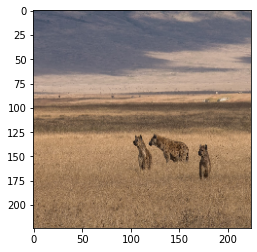

In [0]:
#loading the image 

from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input, decode_predictions
import numpy as np
import matplotlib.pyplot as plt
img_path='/content/hyenas1.jfif'

img=image.load_img(img_path, target_size=(224,224,3))
plt.imshow(img)
x=image.img_to_array(img)
#plt.imshow(x)
x=np.expand_dims(x,axis=0)

x=preprocess_input(x) #preprocess the image as it was done for training the VGG16
#plt.imshow(x[0])


In [0]:
#predicting the image using VGG16 Architecture and also printing the the top 5 prediction scores.

preds=model.predict(x)
print("predicted:",decode_predictions(preds, top=5)[0])

pred_score=decode_predictions(preds, top=3)[0][0][2]
print("\n The prediction score of the predicted class : {} is = {}:".format(decode_predictions(preds, top=3)[0][0][1],pred_score))


40960/35363 [==================================] - 0s 0us/step
predicted: [('n02117135', 'hyena', 0.45650253), ('n02397096', 'warthog', 0.14413808), ('n02116738', 'African_hunting_dog', 0.0581497), ('n02114855', 'coyote', 0.038355622), ('n02391049', 'zebra', 0.028598586)]

 The prediction score of the predicted class : hyena is = 0.4565025269985199:


In [0]:
#Implementing the Grad CAM

a=np.argmax(preds[0]) # storing the index of the predicted class in variable a


#setting up the gradcam
import keras.backend as K

african_elephant_output=model.output[:,a]

last_conv_layer=model.get_layer('block5_conv3')

# calculating the gradient of the output w.r.t last_conv_layer(14,15,512)
grads=K.gradients(african_elephant_output, last_conv_layer.output)[0] 

# here in pooled grads the gradient values of (14,14) are avergaed for each layer.for 512 channels, there are 512 values after the mean.
pooled_grads=K.mean(grads, axis=(0,1,2)) 

#iterate lets you access the values of the layers when input image is given. As can be seen below the iterate([x]) gives us the pooled_grads and conv_output_layer values.

iterate=K.function([model.input],[pooled_grads, last_conv_layer.output[0]])
pooled_grads_value, conv_layer_output_value=iterate([x])

(14, 14)


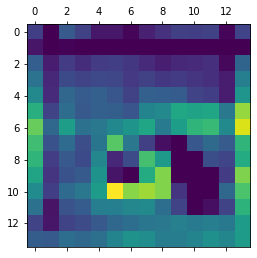

In [0]:
#creating the heatmap

#the for loop multiplies each layer in last convolutional layer with the mean of the gradients for that layer.
for i in range(512):
  conv_layer_output_value[:,:,i]*=pooled_grads_value[i]



heatmap=np.mean(conv_layer_output_value, axis=-1)
print(heatmap.shape)

#applying the ReLU on the heatmap. This removes all the values, that negatively influences the predicted class.
heatmap=np.maximum(heatmap,0)

#we normalize the heatmap to bring all the values between 0 and 1.
heatmap/=np.max(heatmap)
plt.matshow(heatmap)

In [0]:
# projecting the heatmap on the image

import cv2
from google.colab.patches import cv2_imshow
img=cv2.imread(img_path)

#resize the heatmap to the size of the input image
heatmap=cv2.resize(heatmap,(img.shape[1], img.shape[0]))
heatmap=np.uint8(255*heatmap)

heatmap=cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

superimposed_img=heatmap*0.4+img

cv2.imwrite('heatmap3.jpeg',superimposed_img)




True

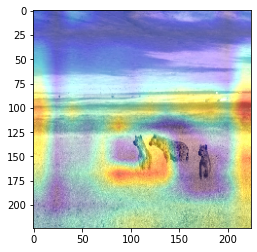

In [0]:
img_path='/content/heatmap3.jpeg'
img=image.load_img(img_path, target_size=(224,224,3))
plt.imshow(img)